In [1]:
# import packages
import sys
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import datestr2num
import datetime
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from fbprophet import Prophet
import holidays

Importing plotly failed. Interactive plots will not work.


In [1]:
df = pd.read_csv("data_final.csv")
df['Date'] = df["time"]

In [58]:
def make_predictions_df(forecast, data): 
    """
    Function to convert the output Prophet dataframe to a datetime index and append the actual target values at the end
    :param forecast: the Prophet training dataframe
    :param data: the data used for evaluate model performance with target closing price values
    :return forecast: the Prophet training dataframe with target values at the end
    """
    # create file folder to save plots
    if not os.path.exists("figures_model_evaluation"):
        os.makedirs("figures_model_evaluation")

    forecast.index = pd.to_datetime(forecast.ds)
    data.index = pd.to_datetime(data.ds)
    forecast.loc[:,'y'] = data.loc[:,'y']

    return forecast,data

def plot_predictions(forecast, start_date):
    """
    Function to plot the predictions 
    """
    f, ax = plt.subplots(figsize=(8, 5))
    plt.xlabel("Date")
    plt.ylabel("Power Price (TEUR/MWH)")
    forecast.index = pd.to_datetime(forecast.ds)
    
    train = forecast.loc[start_date:'2021-11-7',:]
    ax.plot(train.index, train.y, 'ko', markersize=3)
    ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)
    ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)
    
    test = forecast.loc['2021-11-7':'2025-7-13',]
    ax.plot(test.index, test.y, 'ro', markersize=2)
    ax.plot(test.index, test.yhat, color='coral', lw=0.5)
    ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)
    ax.grid(ls=':', lw=0.5)
    
    return f, ax


In [40]:
# def evaluate(joined_data_for_pred, joined_data_capped):
def evaluate(data):
    """
    Function to predict stocking price using Prophet
    :param joined_data_for_pred: the data used for evaluate model performance with target closing price values
    :param joined_data_capped: the data used for model training and performance evaluation
    """
    
    # create file folder to save plots
    if not os.path.exists("figures_model_evaluation"):
        os.makedirs("figures_model_evaluation")
        
#     data = joined_data_capped.append(joined_data_for_pred)
    data = data.fillna(method='ffill')
    data['Date'] = pd.to_datetime(data['Date'])
    data = data[['Date', "power"]]
    data = data.set_index(['Date'])
    new_index = pd.date_range(start='2020-01-01', end='2022-07-13', freq="D")
    new_data = data.reindex(new_index, method = "nearest")
    new_data.reset_index(inplace=True)
    new_data = new_data.rename({'index':'ds','power':'y'}, axis=1)
    new_data = new_data[['ds', 'y']]
    new_data
    
    # take holidays and special events into consideration when modelling time-series data
    holidays_df = pd.DataFrame([], columns = ['ds','holiday'])
    ldates = []
    lnames = []
    for date, name in sorted(holidays.England(years=np.arange(2017, 2021 + 1)).items()):
        ldates.append(date)
        lnames.append(name)

    ldates = np.array(ldates)
    lnames = np.array(lnames)
    holidays_df.loc[:,'ds'] = ldates
    holidays_df.loc[:,'holiday'] = lnames
    holidays_df.holiday.unique()
    holidays_df.loc[:,'holiday'] = holidays_df.loc[:,'holiday'].apply(lambda x : x.replace(' (Observed)',''))
    
    train = new_data.set_index('ds').loc[:'2021-11-7', :].reset_index()
    test = new_data.set_index('ds').loc['2022-7-13':, :].reset_index()
    train.to_csv("stock-data1/prophet_train.csv")
    test.to_csv("stock-data1/prophet_test.csv")
    data = train.append(test)
    data.to_csv("stock-data1/prophet_data.csv")
    
    # train the model
    m = Prophet(holidays=holidays_df,
            seasonality_mode='multiplicative',
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False)
    m.fit(train)
    
    # forecast
    future = m.make_future_dataframe(periods=len(test), freq='1D')
    forecast = m.predict(future)
    forecast.to_csv("stock-data1/prophet_forecast.csv")
    forecast
    f = m.plot_components(forecast, figsize=(12, 16)).savefig("figures_model_evaluation/prediction_analysis.jpg")
    plt.close('all')
    
    result = make_predictions_df(forecast, data)
    result.loc[:,'yhat'] = result.yhat.clip(lower=0)
    result.loc[:,'yhat_lower'] = result.yhat_lower.clip(lower=0)
    result.loc[:, 'yhat_upper'] = result.yhat_upper.clip(lower=0)
    
    f, ax = plot_predictions(result, '2020-01-01')
    return forecast


1


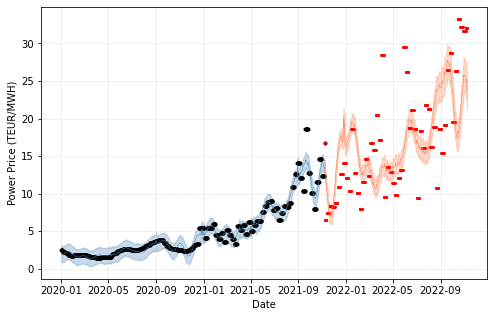

In [59]:
data = df
evaluate(data)
